In [1]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

# 5.1. Multilayer Perceptrons

## ReLU
$$\operatorname{ReLU}(x) = \max(x, 0)$$
$$\frac{d}{dx} \operatorname{ReLU}(x) =
\begin{cases} 
1, & x > 0 \\ 
0, & x \le 0
\end{cases}
$$

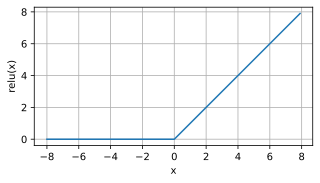

In [2]:
# ReLU
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), "x", "relu(x)", figsize=(5, 2.5))

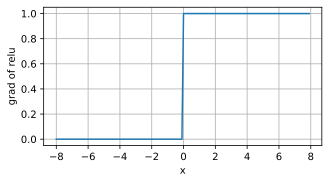

In [3]:
# derivative of ReLU
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, "x", "grad of relu", figsize=(5, 2.5))

## Sigmoid
$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}$$
 its gradient vanishes for large positive and negative arguments
 $$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right)$$

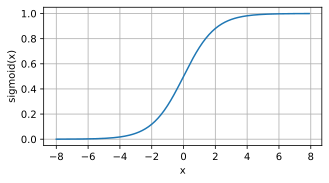

In [4]:
# Sigmoid
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), "x", "sigmoid(x)", figsize=(5, 2.5))

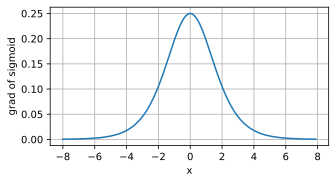

In [5]:
# derivative of Sigmoid
x.grad.data.zero_()  # Clear out previous gradients
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, "x", "grad of sigmoid", figsize=(5, 2.5))

## Tanh
$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}$$
its gradient vanishes for large positive and negative arguments
$$\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x)$$

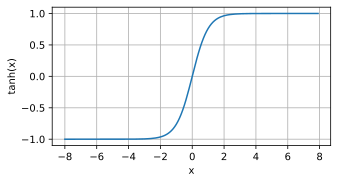

In [6]:
# Tanh
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), "x", "tanh(x)", figsize=(5, 2.5))

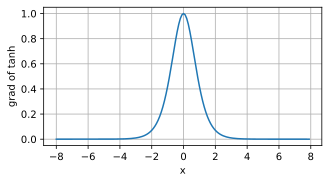

In [7]:
# derivative of Tanh
x.grad.data.zero_()  # Clear out previous gradients
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, "x", "grad of tanh", figsize=(5, 2.5))

# 5.2. Implementation of Multilayer Perceptrons

## 5.2.1. Implementation from Scratch

In [8]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [9]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [10]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

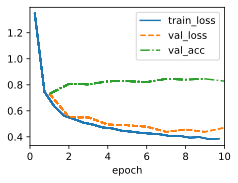

In [11]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## 5.2.2. Concise Implementation
no forward method is defined here. In fact, MLP inherits the forward method from the Module class (Section 3.2.2) to simply invoke self.net(X) (X is input), which is now defined as a sequence of transformations via the Sequential class. 

In [12]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens),
            nn.ReLU(),
            nn.LazyLinear(num_outputs),
        )

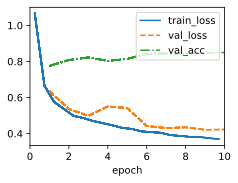

In [13]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

# 5.4. Numerical Stability and Initialization

## 5.4.1. Vanishing and Exploding Gradients

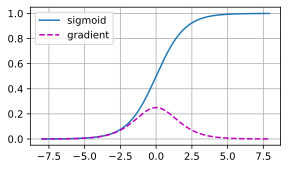

In [14]:
# Sigmoid can cause vanishing gradients
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(
    x.detach().numpy(),
    [y.detach().numpy(), x.grad.numpy()],
    legend=["sigmoid", "gradient"],
    figsize=(4.5, 2.5),
)

In [15]:
# gradients explode
M = torch.normal(0, 1, size=(4, 4))
print("a single matrix \n", M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
print("after multiplying 100 matrices\n", M)

a single matrix 
 tensor([[-1.6949, -2.1414,  0.0189,  2.0938],
        [-1.6490, -0.7727, -0.7375,  1.8044],
        [ 1.1046,  0.4505,  0.3832, -2.5779],
        [ 1.1419, -0.5188, -0.0804, -0.0902]])
after multiplying 100 matrices
 tensor([[-2.8006e+23, -1.2790e+24, -1.4453e+24,  1.6297e+24],
        [-1.1504e+23, -5.2538e+23, -5.9368e+23,  6.6943e+23],
        [-1.4776e+21, -6.7482e+21, -7.6254e+21,  8.5984e+21],
        [ 2.3915e+23,  1.0922e+24,  1.2342e+24, -1.3916e+24]])


# 5.6. Dropout

## 5.6.2. Implementation from Scratch

In [16]:
def dropout_layer(X, dropout):
    """
    drops out the elements in the tensor input X with probability dropout,
    rescaling the remainder as described above: dividing the survivors by 1.0-dropout
    """
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [17]:
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print("dropout_p = 0:", dropout_layer(X, 0))
print("dropout_p = 0.5:", dropout_layer(X, 0.5))
print("dropout_p = 1:", dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  0.,  0.,  8.,  0., 12., 14.],
        [16.,  0., 20., 22.,  0., 26., 28.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [18]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(
        self, num_outputs, num_hiddens_1, num_hiddens_2, dropout_1, dropout_2, lr
    ):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

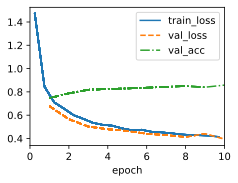

In [19]:
hparams = {
    "num_outputs": 10,
    "num_hiddens_1": 256,
    "num_hiddens_2": 256,
    "dropout_1": 0.5,
    "dropout_2": 0.5,
    "lr": 0.1,
}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## 5.6.3. Concise Implementation

In [20]:
class DropoutMLP(d2l.Classifier):
    """
    add a Dropout layer after each fully connected layer,
    passing in the dropout probability as the only argument to its constructor
    """

    def __init__(
        self, num_outputs, num_hiddens_1, num_hiddens_2, dropout_1, dropout_2, lr
    ):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens_1),
            nn.ReLU(),
            nn.Dropout(dropout_1),
            nn.LazyLinear(num_hiddens_2),
            nn.ReLU(),
            nn.Dropout(dropout_2),
            nn.LazyLinear(num_outputs),
        )

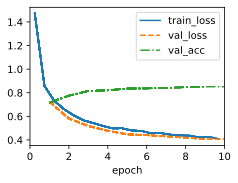

In [21]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

# 5.7. Predicting House Prices on Kaggle

## 5.7.3. Accessing and Reading the Dataset

In [22]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(
                d2l.download(
                    d2l.DATA_URL + "kaggle_house_pred_train.csv",
                    self.root,
                    sha1_hash="585e9cc93e70b39160e7921475f9bcd7d31219ce",
                )
            )
            self.raw_val = pd.read_csv(
                d2l.download(
                    d2l.DATA_URL + "kaggle_house_pred_test.csv",
                    self.root,
                    sha1_hash="fa19780a7b011d9b009e8bff8e99922a8ee2eb90",
                )
            )

In [23]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


## 5.7.4. Data Preprocessing

In [24]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [25]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = "SalePrice"
    features = pd.concat(
        (self.raw_train.drop(columns=["Id", label]), self.raw_val.drop(columns=["Id"]))
    )
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes != "object"].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std())
    )
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[: self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0] :].copy()

In [26]:
data.preprocess()
data.train.shape

(1460, 331)

## 5.7.5. Error Measure

In [27]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = "SalePrice"
    data = self.train if train else self.val
    if label not in data:
        return
    get_tensor = lambda x: torch.tensor(x.values.astype(float), dtype=torch.float32)
    # Logarithm of prices
    tensors = (
        get_tensor(data.drop(columns=[label])),  # X
        torch.log(get_tensor(data[label])).reshape((-1, 1)),
    )  # Y
    return self.get_tensorloader(tensors, train)

## 5.7.6. K-Fold Cross-Validation

In [28]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j + 1) * fold_size)
        rets.append(
            KaggleHouse(
                data.batch_size, data.train.drop(index=idx), data.train.loc[idx]
            )
        )
    return rets

In [29]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale = "log"
        if i != 0:
            model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data["val_loss"][-1].y))
        models.append(model)
    print(f"average validation log mse = {sum(val_loss)/len(val_loss)}")
    return models

## 5.7.7. Model Selection

average validation log mse = 0.1843574410676956


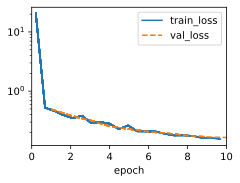

In [30]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

## 5.7.8. Submitting Predictions on Kaggle

In [31]:
preds = [
    model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
    for model in models
]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame(
    {"Id": data.raw_val.Id, "SalePrice": ensemble_preds.detach().numpy()}
)
# submission.to_csv("submission.csv", index=False)